# Task 1: Term Deposit Subscription Prediction (Bank Marketing)

## Problem Statement
The goal of this project is to predict whether a bank customer will subscribe to a **term deposit** as a result of a marketing campaign.  

This is a **binary classification problem** (yes/no), and we will use classification models along with **Explainable AI (XAI)** techniques to understand model predictions.

---

## Objectives
- Load and explore the Bank Marketing dataset.
- Encode categorical features properly.
- Train classification models (Logistic Regression, Random Forest).
- Evaluate models using **Confusion Matrix, F1-Score, and ROC Curve**.
- Use **SHAP or LIME** to explain at least 5 predictions.
- Provide insights into customer behavior and marketing strategies.

---

## Dataset Description
The dataset comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

- **Features** include:
  - Client attributes: `age, job, marital, education, balance`
  - Campaign-related: `contact, day, month, duration, campaign, pdays, previous`
  - Other attributes: `housing, loan, poutcome`
- **Target variable**: `y` → whether the client subscribed (`yes/no`).

---


In [2]:
# 📌 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap  # For explainability
import warnings
warnings.filterwarnings("ignore")

C:\Users\Others\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load the Dataset

In [3]:
# Load dataset
df = pd.read_csv("bank-full.csv", sep=";")

# Display first rows
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Step 2: Explore the Dataset
- Shape of dataset
- Data types
- Missing values
- Target distribution


In [4]:
# Dataset shape
print("Shape:", df.shape)

Shape: (45211, 17)


In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
# Target distribution
print("\nTarget distribution:")
print(df['y'].value_counts(normalize=True))


Target distribution:
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


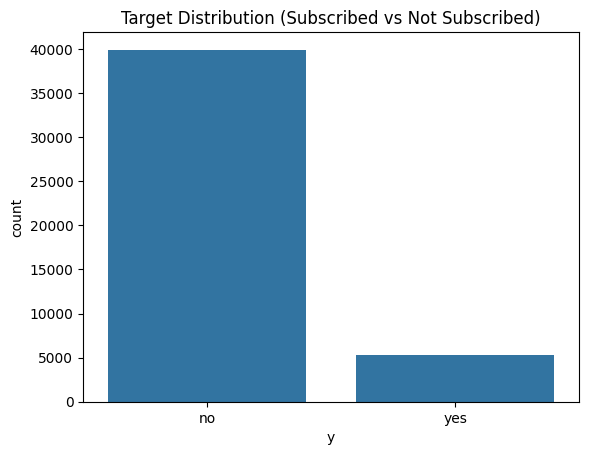

In [7]:
sns.countplot(x="y", data=df)
plt.title("Target Distribution (Subscribed vs Not Subscribed)")
plt.show()

## Step 3: Data Preprocessing
- Encode categorical variables
- Scale numerical variables (for Logistic Regression)
- Train/Test split

In [8]:
# Features and target
X = df.drop("y", axis=1)
y = df["y"].map({"yes":1, "no":0})

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(exclude=["object"]).columns

# Preprocessing pipeline
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (36168, 16) Test shape: (9043, 16)


## Step 4: Model Training
We will train two models:
1. Logistic Regression (baseline linear model)
2. Random Forest Classifier (non-linear ensemble model)


In [9]:
# Logistic Regression Pipeline
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Random Forest Pipeline
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

## Step 5: Model Evaluation
We will evaluate using:
- Confusion Matrix
- Classification Report (F1-Score)
- ROC Curve & AUC


🔎 Logistic Regression Results
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



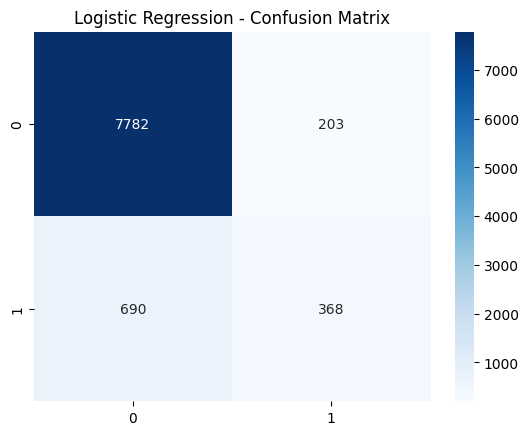

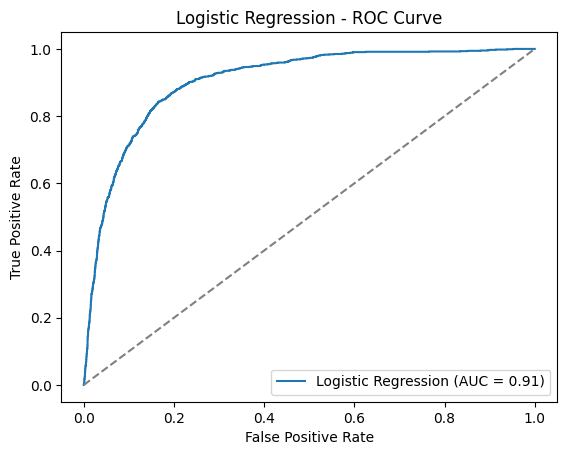

🔎 Random Forest Results
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.67      0.41      0.51      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.69      0.73      9043
weighted avg       0.90      0.91      0.90      9043



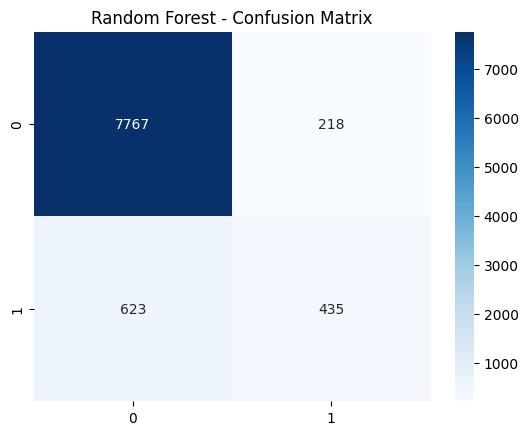

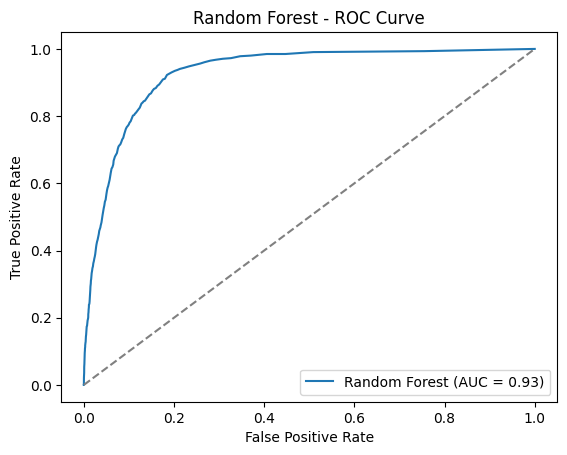

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"{model_name} Results")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.show()

# Evaluate Logistic Regression
evaluate_model(log_reg, X_test, y_test, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(rf, X_test, y_test, "Random Forest")


## Step 6: Explainability with SHAP
We will use **SHAP values** to explain the predictions of the Random Forest model.

In [ ]:
# Extract preprocessed training data
X_preprocessed = preprocessor.fit_transform(X_train)
feature_names = (numeric_cols.tolist() + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

# Train a standalone RandomForest for SHAP
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_preprocessed, y_train)

# SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(preprocessor.transform(X_test))

# Explain first 5 samples
for i in range(5):
    shap.force_plot(explainer.expected_value[1], shap_values[1][i], 
                    feature_names=feature_names, matplotlib=True, show=True)


## Step 7: Insights & Conclusion
- Logistic Regression provides baseline interpretability but lower accuracy.  
- Random Forest achieves higher performance, capturing non-linear patterns.  
- SHAP analysis reveals key drivers of subscription:
  - **Contact method** (cellular is more effective).
  - **Campaign duration** (longer calls often lead to success).
  - **Client balance & age** play a major role.
- Business Insight: Marketing strategies should target clients with higher balances, specific job types, and use effective contact methods (cellular, recent contact).